# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

2023-10-16 12:05:01.057384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 12:05:01.696061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 50
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [7]:
tokenizer = get_tokenizer("basic_english")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

In [9]:

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  2049990
Valid Tokens:  214417
Test Tokens:  241859
Total number of tokens: 2506266


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 28785


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:
train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, hidden = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, hidden = self.rnn2(output,hidden)
    output = self.dropout2(output)
    
    output, hidden = self.rnn3(output,hidden)
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 34.825785



H_LSTM(
  (embedding): Embedding(28785, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=28785, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 1640/1640 [04:51<00:00,  5.63batch/s, loss=6.49, perplexity=894]    


Valid: Loss = 5.823 Perplexity= 345.6, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 1640/1640 [04:54<00:00,  5.57batch/s, loss=5.9, perplexity=376] 


Valid: Loss = 5.558 Perplexity= 265.6, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 1640/1640 [04:57<00:00,  5.52batch/s, loss=5.65, perplexity=293]


Valid: Loss = 5.384 Perplexity= 223.7, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 1640/1640 [04:57<00:00,  5.52batch/s, loss=5.46, perplexity=243]


Valid: Loss = 5.256 Perplexity= 197.4, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 1640/1640 [04:57<00:00,  5.51batch/s, loss=5.31, perplexity=209]


Valid: Loss = 5.178 Perplexity= 183.0, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 1640/1640 [04:57<00:00,  5.50batch/s, loss=5.19, perplexity=186]


Valid: Loss = 5.128 Perplexity= 174.5, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 1640/1640 [04:57<00:00,  5.51batch/s, loss=5.09, perplexity=169]


Valid: Loss = 5.088 Perplexity= 167.8, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 1640/1640 [04:56<00:00,  5.54batch/s, loss=5, perplexity=155]   


Valid: Loss = 5.046 Perplexity= 161.2, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 1640/1640 [04:57<00:00,  5.51batch/s, loss=4.91, perplexity=142]


Valid: Loss = 5.012 Perplexity= 156.2, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 1640/1640 [04:51<00:00,  5.62batch/s, loss=4.84, perplexity=132]


Valid: Loss = 4.999 Perplexity= 154.3, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 1640/1640 [04:58<00:00,  5.50batch/s, loss=4.76, perplexity=122]


Valid: Loss = 4.936 Perplexity= 144.8, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 1640/1640 [04:57<00:00,  5.51batch/s, loss=4.67, perplexity=112]


Valid: Loss = 4.915 Perplexity= 141.8, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 1640/1640 [04:57<00:00,  5.51batch/s, loss=4.6, perplexity=104] 


Valid: Loss = 4.849 Perplexity= 132.7, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 1640/1640 [04:56<00:00,  5.52batch/s, loss=4.53, perplexity=97]  


Valid: Loss = 4.808 Perplexity= 127.6, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 1640/1640 [04:56<00:00,  5.53batch/s, loss=4.46, perplexity=90.3]


Valid: Loss = 4.778 Perplexity= 123.9, LR = 0.5
Model Saved!



Epoch 15: 100%|██████████| 1640/1640 [04:38<00:00,  5.89batch/s, loss=4.4, perplexity=85]   


Valid: Loss = 4.765 Perplexity= 122.3, LR = 0.5
Model Saved!



Epoch 16: 100%|██████████| 1640/1640 [04:23<00:00,  6.21batch/s, loss=4.34, perplexity=80.4]


Valid: Loss = 4.714 Perplexity= 116.2, LR = 0.5
Model Saved!



Epoch 17: 100%|██████████| 1640/1640 [04:23<00:00,  6.21batch/s, loss=4.29, perplexity=76.4]


Valid: Loss = 4.667 Perplexity= 110.8, LR = 0.5
Model Saved!



Epoch 18: 100%|██████████| 1640/1640 [04:23<00:00,  6.21batch/s, loss=4.25, perplexity=73.5]


Valid: Loss = 4.659 Perplexity= 110.1, LR = 0.5
Model Saved!



Epoch 19: 100%|██████████| 1640/1640 [04:23<00:00,  6.21batch/s, loss=4.2, perplexity=69.9] 


Valid: Loss = 4.64 Perplexity= 108.1, LR = 0.5
Model Saved!



Epoch 20: 100%|██████████| 1640/1640 [04:23<00:00,  6.22batch/s, loss=4.16, perplexity=66.9]


Valid: Loss = 4.617 Perplexity= 105.7, LR = 0.5
Model Saved!



Epoch 21: 100%|██████████| 1640/1640 [04:23<00:00,  6.22batch/s, loss=4.11, perplexity=63.6]


Valid: Loss = 4.539 Perplexity= 97.45, LR = 0.5
Model Saved!



Epoch 22: 100%|██████████| 1640/1640 [04:42<00:00,  5.80batch/s, loss=4.06, perplexity=60.6]


Valid: Loss = 4.543 Perplexity= 98.14, LR = 0.5



Epoch 23: 100%|██████████| 1640/1640 [04:43<00:00,  5.79batch/s, loss=3.92, perplexity=52.9]


Valid: Loss = 4.406 Perplexity= 85.48, LR = 0.25
Model Saved!



Epoch 24: 100%|██████████| 1640/1640 [04:32<00:00,  6.01batch/s, loss=3.84, perplexity=48.7]


Valid: Loss = 4.361 Perplexity= 81.74, LR = 0.25
Model Saved!



Epoch 25: 100%|██████████| 1640/1640 [04:55<00:00,  5.55batch/s, loss=3.79, perplexity=46.4]


Valid: Loss = 4.323 Perplexity= 78.72, LR = 0.25
Model Saved!



Epoch 26: 100%|██████████| 1640/1640 [04:58<00:00,  5.49batch/s, loss=3.75, perplexity=44.5]


Valid: Loss = 4.298 Perplexity= 76.7, LR = 0.25
Model Saved!



Epoch 27: 100%|██████████| 1640/1640 [04:57<00:00,  5.51batch/s, loss=3.72, perplexity=43]  


Valid: Loss = 4.273 Perplexity= 74.76, LR = 0.25
Model Saved!



Epoch 28: 100%|██████████| 1640/1640 [04:57<00:00,  5.51batch/s, loss=3.68, perplexity=41.4]


Valid: Loss = 4.288 Perplexity= 76.06, LR = 0.25



Epoch 29: 100%|██████████| 1640/1640 [04:57<00:00,  5.52batch/s, loss=3.6, perplexity=38.1] 


Valid: Loss = 4.176 Perplexity= 68.0, LR = 0.125
Model Saved!



Epoch 30: 100%|██████████| 1640/1640 [04:56<00:00,  5.53batch/s, loss=3.54, perplexity=36]  


Valid: Loss = 4.143 Perplexity= 65.77, LR = 0.125
Model Saved!



Epoch 31: 100%|██████████| 1640/1640 [04:56<00:00,  5.53batch/s, loss=3.51, perplexity=34.8]


Valid: Loss = 4.105 Perplexity= 63.29, LR = 0.125
Model Saved!



Epoch 32: 100%|██████████| 1640/1640 [04:40<00:00,  5.84batch/s, loss=3.48, perplexity=33.8]


Valid: Loss = 4.071 Perplexity= 61.14, LR = 0.125
Model Saved!



Epoch 33: 100%|██████████| 1640/1640 [04:23<00:00,  6.21batch/s, loss=3.45, perplexity=32.9]


Valid: Loss = 4.071 Perplexity= 61.17, LR = 0.125



Epoch 34: 100%|██████████| 1640/1640 [04:23<00:00,  6.22batch/s, loss=3.41, perplexity=31.5]


Valid: Loss = 4.016 Perplexity= 57.83, LR = 0.0625
Model Saved!



Epoch 35: 100%|██████████| 1640/1640 [04:23<00:00,  6.22batch/s, loss=3.38, perplexity=30.4]


Valid: Loss = 3.979 Perplexity= 55.7, LR = 0.0625
Model Saved!



Epoch 36: 100%|██████████| 1640/1640 [04:23<00:00,  6.22batch/s, loss=3.35, perplexity=29.7]


Valid: Loss = 3.95 Perplexity= 54.14, LR = 0.0625
Model Saved!



Epoch 37: 100%|██████████| 1640/1640 [04:23<00:00,  6.22batch/s, loss=3.33, perplexity=29]  


Valid: Loss = 3.934 Perplexity= 53.24, LR = 0.0625
Model Saved!



Epoch 38: 100%|██████████| 1640/1640 [04:23<00:00,  6.22batch/s, loss=3.31, perplexity=28.5]


Valid: Loss = 3.923 Perplexity= 52.65, LR = 0.0625
Model Saved!



Epoch 39: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.29, perplexity=27.9]


Valid: Loss = 3.917 Perplexity= 52.35, LR = 0.0625
Model Saved!



Epoch 40: 100%|██████████| 1640/1640 [04:23<00:00,  6.22batch/s, loss=3.28, perplexity=27.5]


Valid: Loss = 3.903 Perplexity= 51.67, LR = 0.0625
Model Saved!



Epoch 41: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.26, perplexity=27.1]


Valid: Loss = 3.894 Perplexity= 51.18, LR = 0.0625
Model Saved!



Epoch 42: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.24, perplexity=26.6]


Valid: Loss = 3.867 Perplexity= 49.85, LR = 0.0625
Model Saved!



Epoch 43: 100%|██████████| 1640/1640 [04:32<00:00,  6.02batch/s, loss=3.23, perplexity=26.2]


Valid: Loss = 3.869 Perplexity= 49.96, LR = 0.0625



Epoch 44: 100%|██████████| 1640/1640 [04:54<00:00,  5.56batch/s, loss=3.2, perplexity=25.4] 


Valid: Loss = 3.824 Perplexity= 47.7, LR = 0.03125
Model Saved!



Epoch 45: 100%|██████████| 1640/1640 [04:54<00:00,  5.56batch/s, loss=3.18, perplexity=24.9]


Valid: Loss = 3.802 Perplexity= 46.65, LR = 0.03125
Model Saved!



Epoch 46: 100%|██████████| 1640/1640 [04:54<00:00,  5.57batch/s, loss=3.16, perplexity=24.5]


Valid: Loss = 3.793 Perplexity= 46.28, LR = 0.03125
Model Saved!



Epoch 47: 100%|██████████| 1640/1640 [04:54<00:00,  5.56batch/s, loss=3.15, perplexity=24.2]


Valid: Loss = 3.784 Perplexity= 45.86, LR = 0.03125
Model Saved!



Epoch 48: 100%|██████████| 1640/1640 [04:55<00:00,  5.56batch/s, loss=3.14, perplexity=23.9]


Valid: Loss = 3.771 Perplexity= 45.22, LR = 0.03125
Model Saved!



Epoch 49: 100%|██████████| 1640/1640 [04:42<00:00,  5.80batch/s, loss=3.13, perplexity=23.7]


Valid: Loss = 3.763 Perplexity= 44.86, LR = 0.03125
Model Saved!



Epoch 50: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.12, perplexity=23.4]


Valid: Loss = 3.761 Perplexity= 44.79, LR = 0.03125
Model Saved!



Epoch 51: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.11, perplexity=23.2]


Valid: Loss = 3.749 Perplexity= 44.28, LR = 0.03125
Model Saved!



Epoch 52: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.1, perplexity=22.9] 


Valid: Loss = 3.728 Perplexity= 43.34, LR = 0.03125
Model Saved!



Epoch 53: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.09, perplexity=22.7]


Valid: Loss = 3.726 Perplexity= 43.22, LR = 0.03125
Model Saved!



Epoch 54: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.08, perplexity=22.5]


Valid: Loss = 3.728 Perplexity= 43.35, LR = 0.03125



Epoch 55: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.06, perplexity=22.1]


Valid: Loss = 3.704 Perplexity= 42.33, LR = 0.015625
Model Saved!



Epoch 56: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.05, perplexity=21.8]


Valid: Loss = 3.674 Perplexity= 41.08, LR = 0.015625
Model Saved!



Epoch 57: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.04, perplexity=21.6]


Valid: Loss = 3.675 Perplexity= 41.07, LR = 0.015625
Model Saved!



Epoch 58: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.03, perplexity=21.5]


Valid: Loss = 3.681 Perplexity= 41.34, LR = 0.015625



Epoch 59: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.03, perplexity=21.5]


Valid: Loss = 3.638 Perplexity= 39.61, LR = 0.0078125
Model Saved!



Epoch 60: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=3.03, perplexity=21.4]


Valid: Loss = 3.625 Perplexity= 39.08, LR = 0.0078125
Model Saved!



Epoch 61: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=3.02, perplexity=21.2]


Valid: Loss = 3.621 Perplexity= 38.95, LR = 0.0078125
Model Saved!



Epoch 62: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=3.01, perplexity=21.1]


Valid: Loss = 3.616 Perplexity= 38.73, LR = 0.0078125
Model Saved!



Epoch 63: 100%|██████████| 1640/1640 [04:23<00:00,  6.24batch/s, loss=3.01, perplexity=21]  


Valid: Loss = 3.617 Perplexity= 38.79, LR = 0.0078125



Epoch 64: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=3.01, perplexity=21.1]


Valid: Loss = 3.59 Perplexity= 37.73, LR = 0.00390625
Model Saved!



Epoch 65: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=3.01, perplexity=21.1]


Valid: Loss = 3.583 Perplexity= 37.45, LR = 0.00390625
Model Saved!



Epoch 66: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=3.01, perplexity=21.1]


Valid: Loss = 3.574 Perplexity= 37.12, LR = 0.00390625
Model Saved!



Epoch 67: 100%|██████████| 1640/1640 [04:22<00:00,  6.25batch/s, loss=3.01, perplexity=21]  


Valid: Loss = 3.571 Perplexity= 36.99, LR = 0.00390625
Model Saved!



Epoch 68: 100%|██████████| 1640/1640 [04:22<00:00,  6.25batch/s, loss=3, perplexity=20.9]  


Valid: Loss = 3.57 Perplexity= 36.98, LR = 0.00390625
Model Saved!



Epoch 69: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=3, perplexity=20.9]   


Valid: Loss = 3.571 Perplexity= 37.01, LR = 0.00390625



Epoch 70: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=3.01, perplexity=21]  


Valid: Loss = 3.543 Perplexity= 35.97, LR = 0.001953125
Model Saved!



Epoch 71: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=3, perplexity=20.8]   


Valid: Loss = 3.54 Perplexity= 35.86, LR = 0.001953125
Model Saved!



Epoch 72: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=3, perplexity=20.8]   


Valid: Loss = 3.541 Perplexity= 35.89, LR = 0.001953125



Epoch 73: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=3, perplexity=20.8]   


Valid: Loss = 3.529 Perplexity= 35.47, LR = 0.0009765625
Model Saved!



Epoch 74: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=2.99, perplexity=20.7]


Valid: Loss = 3.527 Perplexity= 35.4, LR = 0.0009765625
Model Saved!



Epoch 75: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=2.99, perplexity=20.7]


Valid: Loss = 3.526 Perplexity= 35.35, LR = 0.0009765625
Model Saved!



Epoch 76: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=2.99, perplexity=20.6]


Valid: Loss = 3.524 Perplexity= 35.28, LR = 0.0009765625
Model Saved!



Epoch 77: 100%|██████████| 1640/1640 [04:26<00:00,  6.16batch/s, loss=2.99, perplexity=20.6]


Valid: Loss = 3.524 Perplexity= 35.3, LR = 0.0009765625



Epoch 78: 100%|██████████| 1640/1640 [04:45<00:00,  5.75batch/s, loss=2.99, perplexity=20.6]


Valid: Loss = 3.519 Perplexity= 35.1, LR = 0.00048828125
Model Saved!



Epoch 79: 100%|██████████| 1640/1640 [04:55<00:00,  5.55batch/s, loss=2.99, perplexity=20.5]


Valid: Loss = 3.52 Perplexity= 35.12, LR = 0.00048828125



Epoch 80: 100%|██████████| 1640/1640 [04:55<00:00,  5.54batch/s, loss=2.99, perplexity=20.6]


Valid: Loss = 3.517 Perplexity= 35.03, LR = 0.000244140625
Model Saved!



Epoch 81: 100%|██████████| 1640/1640 [04:55<00:00,  5.55batch/s, loss=2.99, perplexity=20.5]


Valid: Loss = 3.516 Perplexity= 35.0, LR = 0.000244140625
Model Saved!



Epoch 82: 100%|██████████| 1640/1640 [04:55<00:00,  5.56batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.515 Perplexity= 34.97, LR = 0.000244140625
Model Saved!



Epoch 83: 100%|██████████| 1640/1640 [04:55<00:00,  5.56batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.515 Perplexity= 34.97, LR = 0.000244140625
Model Saved!



Epoch 84: 100%|██████████| 1640/1640 [04:31<00:00,  6.04batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.515 Perplexity= 34.94, LR = 0.000244140625
Model Saved!



Epoch 85: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.515 Perplexity= 34.96, LR = 0.000244140625



Epoch 86: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.513 Perplexity= 34.9, LR = 0.0001220703125
Model Saved!



Epoch 87: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.513 Perplexity= 34.88, LR = 0.0001220703125
Model Saved!



Epoch 88: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.513 Perplexity= 34.88, LR = 0.0001220703125
Model Saved!



Epoch 89: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.513 Perplexity= 34.87, LR = 0.0001220703125
Model Saved!



Epoch 90: 100%|██████████| 1640/1640 [04:23<00:00,  6.23batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.512 Perplexity= 34.86, LR = 0.0001220703125
Model Saved!



Epoch 91: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.512 Perplexity= 34.84, LR = 0.0001220703125
Model Saved!



Epoch 92: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.512 Perplexity= 34.84, LR = 0.0001220703125
Model Saved!



Epoch 93: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.511 Perplexity= 34.83, LR = 0.0001220703125
Model Saved!



Epoch 94: 100%|██████████| 1640/1640 [04:39<00:00,  5.87batch/s, loss=2.98, perplexity=20.4]


Valid: Loss = 3.512 Perplexity= 34.84, LR = 0.0001220703125



Epoch 95: 100%|██████████| 1640/1640 [04:54<00:00,  5.57batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.511 Perplexity= 34.8, LR = 6.103515625e-05
Model Saved!



Epoch 96: 100%|██████████| 1640/1640 [04:53<00:00,  5.59batch/s, loss=2.98, perplexity=20.5]


Valid: Loss = 3.51 Perplexity= 34.8, LR = 6.103515625e-05
Model Saved!



Epoch 97:   3%|▎         | 56/1640 [00:10<04:52,  5.41batch/s, loss=3.13, perplexity=23.3]


KeyboardInterrupt: 

## Learning Curve

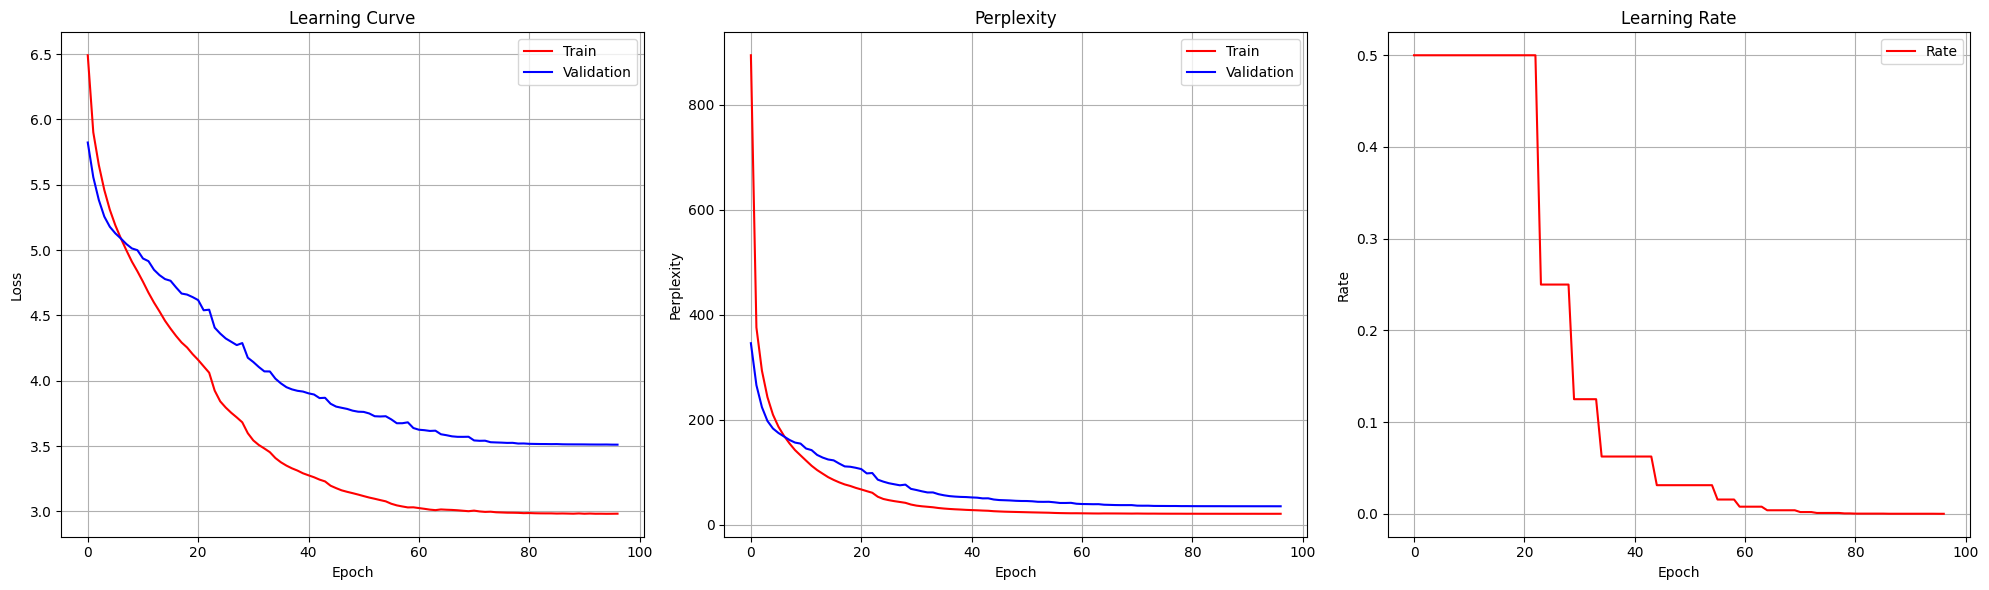

In [19]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [20]:
#LanguageModel = H_LSTM

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 3.51 , Perplexity = 34.8
Test: Loss = 3.458 , Perplexity = 33.59


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(28785, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=28785, bias=True)
)

In [22]:
num_trainable_params(model)

34.825785

In [48]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie begins with poor success .
